In [1]:
import keras
import numpy as np
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Using TensorFlow backend.


In [2]:
# Caminho para os logs do tensorboard e nome do modelo
path, name = "logs", "Model2"

# Importar os dados

In [3]:
test_data = np.load("Test_Data.npy", allow_pickle=True)
train_data = np.load("Train_Data.npy", allow_pickle=True)

Normalizar os dados entre 0 e 1 utilizando máximo e mínimo?
Normalização linear com picos nos dados poderá diluir o resto dos dados?

In [4]:
# TODO: normalizar os dados
x_train, y_train, x_test, y_test = [], [], [], []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)
    
x_train = np.array(x_train).reshape(-1, 69)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(-1, 69)
y_test = np.array(y_test)

In [5]:
print(f"Train features: {x_train.shape} | Train_labels: {y_train.shape}")
print(f"Test features: {x_test.shape} | Test_labels: {y_test.shape}")

Train features: (1345389, 69) | Train_labels: (1345389,)
Test features: (149487, 69) | Test_labels: (149487,)


# Criar o modelo

Cada elemento tem 69 parâmetros que o modelo pode avaliar, logo terá um input layer com 69 entradas

In [20]:
keras.backend.clear_session()

inputs = keras.Input(shape=(69,))
fc1 = keras.layers.Dense(100, activation='relu')(inputs)
d1 = keras.layers.Dropout(0.1)(fc1, training=True)
bn1 = keras.layers.BatchNormalization()(d1)
fc2 = keras.layers.Dense(150, activation='relu')(bn1)
d2 = keras.layers.Dropout(0.1)(fc2, training=True)
bn2 = keras.layers.BatchNormalization()(d2)
fc3 = keras.layers.Dense(200, activation='relu')(bn2)
d3 = keras.layers.Dropout(0.1)(fc3, training=True)
bn3 = keras.layers.BatchNormalization()(d3)
fc4 = keras.layers.Dense(120, activation='relu')(bn3)
d4 = keras.layers.Dropout(0.1)(fc4, training=True)
bn4 = keras.layers.BatchNormalization()(d4)
fc5 = keras.layers.Dense(60, activation='relu')(bn4)
bn5 = keras.layers.BatchNormalization()(fc5)
outputs = keras.layers.Dense(2, activation='softmax')(bn5)
model = keras.Model(inputs, outputs)

model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 69)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               7000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 150)               15150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 150)               600 

# Callbacks

In [7]:
# Tensorboard
TB = keras.callbacks.TensorBoard(path+"/"+name)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("Models/"+name+".h5", save_best_only=True, 
                                     monitor="val_loss", mode="min")

# Treinar modelo

In [ ]:
model.fit(x_train, y_train, validation_split=0.1, shuffle=True,
          batch_size=64, epochs=20, callbacks=[TB, ES, MC])

# Testar e guardar modelo

In [9]:
# model.save("Models/" + name + ".h5")
model = keras.models.load_model("Models/Model1.h5")

In [8]:
num_models, predictions = 100, []

for _ in tqdm(range(num_models), desc='Assembly of models'):
    predictions.append(model.predict(x_test))
    
predictions = np.array(predictions)
print(predictions.shape)

Assembly of models: 100%|██████████| 100/100 [08:35<00:00,  5.16s/it]

(100, 149487, 2)


In [9]:
predictions = predictions.argmax(axis=-1)
print(predictions.shape)

(100, 149487)


In [10]:
recover = predictions

In [11]:
model_scores = [accuracy_score(predictions[i], y_test) for i in range(num_models)]
model_mean, model_std = np.mean(model_scores), np.std(model_scores)

In [12]:
print(f"Models Mean: {model_mean} | Models Std: {model_std}")

Models Mean: 0.5413403841136687 | Models Std: 0.0011957491356831883


In [13]:
MC_Prediction = [np.bincount(predictions[:,i]).argmax() for i in range(len(y_test))]
MC_Prediction = np.array(MC_Prediction)

In [14]:
MC_Accuracy = accuracy_score(MC_Prediction, y_test)
print(MC_Accuracy)

0.5726451129529658


# Plot dos resultados

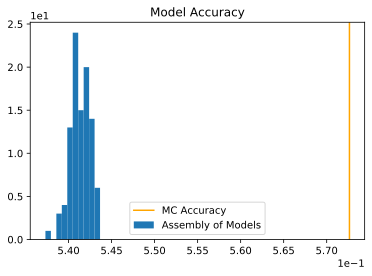

In [15]:
plt.title("Model Accuracy")
plt.hist(model_scores, label='Assembly of Models')
plt.axvline(x=MC_Accuracy, color='orange', label='MC Accuracy')
plt.ticklabel_format(style='sci', scilimits=(0, 0))
plt.legend()
plt.show()